# 2-7. 프로젝트: ResNet Ablation Study


### 0) 라이브러리 버전 확인하기
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


### cats vs dogs 데이터 불러오기

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3.disable_warnings()
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

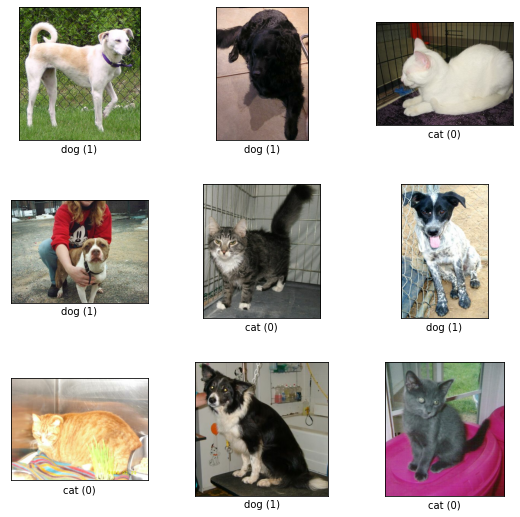

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

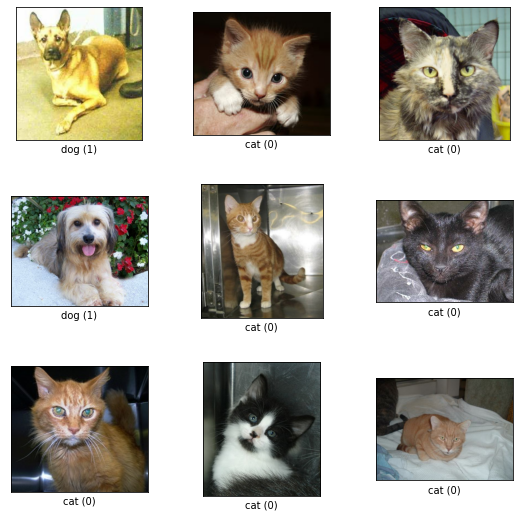

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

In [12]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
BATCH_SIZE = 16
EPOCH = 10

In [15]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### 1) ResNet 기본 블록 구성하기
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

- Deep Residual Learning for Image Recognition(paper)
    - https://arxiv.org/pdf/1512.03385.pdf
- 빛과 같은 카이밍허님의 깃헙
    - https://github.com/KaimingHe/deep-residual-networks

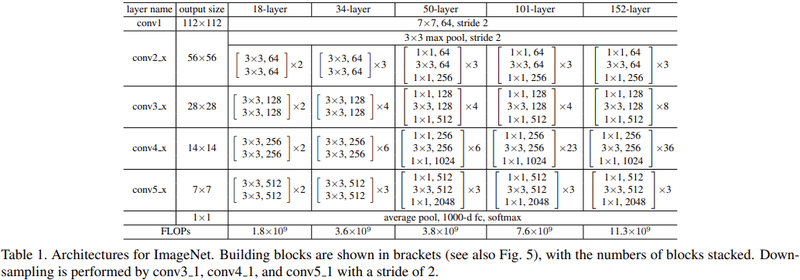

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. Learning by Doing 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.

우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇 번의 경험이 있습니다.
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.

그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.

하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현 방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.

### ResNet 34

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

def resnet_block(inputs, filters, strides=1, activation='relu'):
    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides)(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = layers.Add()([x, shortcut])
    x = layers.Activation(activation)(x)
    return x

def ResNet_34(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = resnet_block(x, 64, activation='relu')
    x = resnet_block(x, 64, activation='relu')
    x = resnet_block(x, 64, activation='relu')

    x = resnet_block(x, 128, strides=2, activation='relu')
    x = resnet_block(x, 128, activation='relu')
    x = resnet_block(x, 128, activation='relu')
    x = resnet_block(x, 128, activation='relu')

    x = resnet_block(x, 256, strides=2, activation='relu')
    x = resnet_block(x, 256, activation='relu')
    x = resnet_block(x, 256, activation='relu')
    x = resnet_block(x, 256, activation='relu')
    x = resnet_block(x, 256, activation='relu')
    x = resnet_block(x, 256, activation='relu')

    x = resnet_block(x, 512, strides=2, activation='relu')
    x = resnet_block(x, 512, activation='relu')
    x = resnet_block(x, 512, activation='relu')

    x = keras.layers.Flatten(name='flatten')(x)
    x = keras.layers.Dense(1, activation='sigmoid', name='fc1')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# 모델 생성
input_shape = (32, 32, 3)
num_classes = 2
resnet_34_model = ResNet_34(input_shape, num_classes)

# 모델 요약 출력
resnet_34_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### ResNet 50

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense

def conv_block(inputs, filters, strides=(1, 1)):
    x = Conv2D(filters, (1, 1), strides=strides, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(4 * filters, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    
    shortcut = inputs
    if strides != (1, 1) or inputs.shape[-1] != 4 * filters:
        shortcut = Conv2D(4 * filters, (1, 1), strides=strides, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

def identity_block(inputs, filters):
    x = Conv2D(filters, (1, 1), padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(4 * filters, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    
    return x

def ResNet_50(input_shape, num_classes):
    inputs = Input(shape=(224, 224, 3))
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    x = conv_block(x, 64, strides=(1, 1))
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    
    x = conv_block(x, 128, strides=(2, 2))
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    
    x = conv_block(x, 256, strides=(2, 2))
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    
    x = conv_block(x, 512, strides=(2, 2))
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    
    x = GlobalAveragePooling2D()(x)
    
    num_classes = 1
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the ResNet-50 model
resnet_50_model = ResNet_50(input_shape, num_classes)

resnet_50_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_352 (Conv2D)             (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_352 (BatchN (None, 112, 112, 64) 256         conv2d_352[0][0]                 
__________________________________________________________________________________________________
activation_326 (Activation)     (None, 112, 112, 64) 0           batch_normalization_352[0][0]    
____________________________________________________________________________________________

### 2) ResNet-34, ResNet-50 Complete Model

ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

- ResNet-34

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

In [18]:
resnet_34 = ResNet_34(input_shape=(224, 224, 3), num_classes = 1)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_92 (BatchNo (None, 112, 112, 64) 256         conv2d_92[0][0]                  
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 112, 112, 64) 0           batch_normalization_92[0][0]     
____________________________________________________________________________________________

In [28]:
resnet_50 = ResNet_50(input_shape=(224, 224, 3), num_classes = 1)
resnet_50.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_408 (Conv2D)             (None, 112, 112, 64) 9472        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_408 (BatchN (None, 112, 112, 64) 256         conv2d_408[0][0]                 
__________________________________________________________________________________________________
activation_378 (Activation)     (None, 112, 112, 64) 0           batch_normalization_408[0][0]    
____________________________________________________________________________________________

In [20]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


 193/1163 [===>..........................] - ETA: 1:38 - loss: 0.9350 - accuracy: 0.5508

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 1:32 - loss: 0.9185 - accuracy: 0.5566

 280/1163 [======>.......................] - ETA: 1:30 - loss: 0.9233 - accuracy: 0.5549

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:15 - loss: 0.9244 - accuracy: 0.5539

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1163 [====================>.........] - ETA: 33s - loss: 0.9091 - accuracy: 0.5687

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 30s - loss: 0.9074 - accuracy: 0.5699

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 28s - loss: 0.9058 - accuracy: 0.5712

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 23s - loss: 0.9003 - accuracy: 0.5738

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 21s - loss: 0.8991 - accuracy: 0.5745

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8949 - accuracy: 0.5764

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 184s 117ms/step - loss: 0.8949 - accuracy: 0.5764 - val_loss: 2.2911 - val_accuracy: 0.5371
Epoch 2/10
 195/1163 [====>.........................] - ETA: 1:41 - loss: 0.8481 - accuracy: 0.6048

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:34 - loss: 0.8657 - accuracy: 0.6001

 280/1163 [======>.......................] - ETA: 1:32 - loss: 0.8611 - accuracy: 0.6002

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 1:17 - loss: 0.8661 - accuracy: 0.5934

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1163 [====================>.........] - ETA: 33s - loss: 0.8420 - accuracy: 0.6021

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 30s - loss: 0.8412 - accuracy: 0.6024

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 28s - loss: 0.8404 - accuracy: 0.6029

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 22s - loss: 0.8377 - accuracy: 0.6054

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 21s - loss: 0.8359 - accuracy: 0.6058

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.6100

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.8284 - accuracy: 0.6100 - val_loss: 0.8072 - val_accuracy: 0.6163
Epoch 3/10
 200/1163 [====>.........................] - ETA: 1:41 - loss: 0.7696 - accuracy: 0.6409

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:34 - loss: 0.7698 - accuracy: 0.6417

 283/1163 [======>.......................] - ETA: 1:32 - loss: 0.7733 - accuracy: 0.6387

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:16 - loss: 0.7649 - accuracy: 0.6404

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 33s - loss: 0.7619 - accuracy: 0.6435

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 30s - loss: 0.7623 - accuracy: 0.6436

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 28s - loss: 0.7601 - accuracy: 0.6449

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 23s - loss: 0.7599 - accuracy: 0.6453

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 21s - loss: 0.7587 - accuracy: 0.6458

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7531 - accuracy: 0.6478

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.7531 - accuracy: 0.6478 - val_loss: 0.7599 - val_accuracy: 0.6286
Epoch 4/10
 201/1163 [====>.........................] - ETA: 1:40 - loss: 0.7149 - accuracy: 0.6642

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 1:34 - loss: 0.7163 - accuracy: 0.6677

 282/1163 [======>.......................] - ETA: 1:32 - loss: 0.7175 - accuracy: 0.6647

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:16 - loss: 0.7100 - accuracy: 0.6705

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 33s - loss: 0.6965 - accuracy: 0.6768

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 30s - loss: 0.6955 - accuracy: 0.6768

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 28s - loss: 0.6942 - accuracy: 0.6775

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 22s - loss: 0.6949 - accuracy: 0.6772

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 21s - loss: 0.6938 - accuracy: 0.6779

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.6813

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.6913 - accuracy: 0.6813 - val_loss: 0.7826 - val_accuracy: 0.6894
Epoch 5/10
 199/1163 [====>.........................] - ETA: 1:40 - loss: 0.6275 - accuracy: 0.7126

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 1:34 - loss: 0.6259 - accuracy: 0.7099

 284/1163 [======>.......................] - ETA: 1:32 - loss: 0.6327 - accuracy: 0.7073

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:16 - loss: 0.6304 - accuracy: 0.7025

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 33s - loss: 0.6126 - accuracy: 0.7114

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 30s - loss: 0.6135 - accuracy: 0.7114

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 28s - loss: 0.6113 - accuracy: 0.7132

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 22s - loss: 0.6057 - accuracy: 0.7164

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 21s - loss: 0.6060 - accuracy: 0.7162

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.7193

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.6014 - accuracy: 0.7193 - val_loss: 0.7472 - val_accuracy: 0.6883
Epoch 6/10
 202/1163 [====>.........................] - ETA: 1:40 - loss: 0.5698 - accuracy: 0.7430

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:34 - loss: 0.5723 - accuracy: 0.7401

 284/1163 [======>.......................] - ETA: 1:31 - loss: 0.5665 - accuracy: 0.7424

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 1:16 - loss: 0.5625 - accuracy: 0.7434

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 32s - loss: 0.5343 - accuracy: 0.7550

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 30s - loss: 0.5339 - accuracy: 0.7551

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 28s - loss: 0.5340 - accuracy: 0.7553

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 22s - loss: 0.5311 - accuracy: 0.7573

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 21s - loss: 0.5309 - accuracy: 0.7573

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.7640

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.5209 - accuracy: 0.7640 - val_loss: 0.7493 - val_accuracy: 0.6855
Epoch 7/10
 204/1163 [====>.........................] - ETA: 1:40 - loss: 0.4601 - accuracy: 0.8027

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:34 - loss: 0.4567 - accuracy: 0.8041

 287/1163 [======>.......................] - ETA: 1:31 - loss: 0.4538 - accuracy: 0.8036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 1:16 - loss: 0.4536 - accuracy: 0.7970

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 33s - loss: 0.4265 - accuracy: 0.8119

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 30s - loss: 0.4272 - accuracy: 0.8122

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 28s - loss: 0.4264 - accuracy: 0.8125

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 22s - loss: 0.4238 - accuracy: 0.8134

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 21s - loss: 0.4228 - accuracy: 0.8139

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4177 - accuracy: 0.8166

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.4177 - accuracy: 0.8166 - val_loss: 0.6820 - val_accuracy: 0.7244
Epoch 8/10
 206/1163 [====>.........................] - ETA: 1:39 - loss: 0.3369 - accuracy: 0.8571

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:33 - loss: 0.3376 - accuracy: 0.8541

 287/1163 [======>.......................] - ETA: 1:31 - loss: 0.3395 - accuracy: 0.8530

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:16 - loss: 0.3230 - accuracy: 0.8610

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 32s - loss: 0.3129 - accuracy: 0.8674

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 873/1163 [=====================>........] - ETA: 30s - loss: 0.3122 - accuracy: 0.8675

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 27s - loss: 0.3098 - accuracy: 0.8685

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 22s - loss: 0.3065 - accuracy: 0.8701

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 21s - loss: 0.3060 - accuracy: 0.8703

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.8735

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.2962 - accuracy: 0.8735 - val_loss: 0.7589 - val_accuracy: 0.7412
Epoch 9/10
 205/1163 [====>.........................] - ETA: 1:40 - loss: 0.2376 - accuracy: 0.9000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:34 - loss: 0.2289 - accuracy: 0.9048

 285/1163 [======>.......................] - ETA: 1:32 - loss: 0.2253 - accuracy: 0.9068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 438/1163 [==========>...................] - ETA: 1:16 - loss: 0.2123 - accuracy: 0.9105

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 32s - loss: 0.1971 - accuracy: 0.9185

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 30s - loss: 0.1968 - accuracy: 0.9186

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 27s - loss: 0.1964 - accuracy: 0.9186

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 22s - loss: 0.1957 - accuracy: 0.9197

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 20s - loss: 0.1951 - accuracy: 0.9199

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9239

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 115ms/step - loss: 0.1864 - accuracy: 0.9239 - val_loss: 1.1016 - val_accuracy: 0.7091
Epoch 10/10
 208/1163 [====>.........................] - ETA: 1:40 - loss: 0.1243 - accuracy: 0.9525

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:34 - loss: 0.1224 - accuracy: 0.9536

 289/1163 [======>.......................] - ETA: 1:31 - loss: 0.1206 - accuracy: 0.9542

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 437/1163 [==========>...................] - ETA: 1:16 - loss: 0.1198 - accuracy: 0.9543

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 852/1163 [====================>.........] - ETA: 32s - loss: 0.1157 - accuracy: 0.9554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 30s - loss: 0.1160 - accuracy: 0.9550

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 27s - loss: 0.1155 - accuracy: 0.9551

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 22s - loss: 0.1145 - accuracy: 0.9555

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 21s - loss: 0.1145 - accuracy: 0.9554

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9564

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 115ms/step - loss: 0.1118 - accuracy: 0.9564 - val_loss: 0.8241 - val_accuracy: 0.7616


In [29]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 195/1163 [====>.........................] - ETA: 2:52 - loss: 0.7276 - accuracy: 0.5410

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 2:41 - loss: 0.7208 - accuracy: 0.5508

 282/1163 [======>.......................] - ETA: 2:37 - loss: 0.7218 - accuracy: 0.5499

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1163 [=========>....................] - ETA: 2:12 - loss: 0.7177 - accuracy: 0.5540

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 58s - loss: 0.7078 - accuracy: 0.5683

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 53s - loss: 0.7077 - accuracy: 0.5687

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 49s - loss: 0.7067 - accuracy: 0.5695

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 39s - loss: 0.7052 - accuracy: 0.5715

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 37s - loss: 0.7049 - accuracy: 0.5724

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.5747

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 243s 198ms/step - loss: 0.7042 - accuracy: 0.5747 - val_loss: 1.2039 - val_accuracy: 0.5103
Epoch 2/10
 199/1163 [====>.........................] - ETA: 2:58 - loss: 0.6831 - accuracy: 0.5958

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 2:47 - loss: 0.6821 - accuracy: 0.6041

 277/1163 [======>.......................] - ETA: 2:44 - loss: 0.6840 - accuracy: 0.6020

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 2:17 - loss: 0.6836 - accuracy: 0.5970

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 59s - loss: 0.6828 - accuracy: 0.5993 

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 56s - loss: 0.6828 - accuracy: 0.5990

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 51s - loss: 0.6824 - accuracy: 0.5994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 40s - loss: 0.6820 - accuracy: 0.6001

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 38s - loss: 0.6820 - accuracy: 0.6000

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.6009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 236s 203ms/step - loss: 0.6825 - accuracy: 0.6009 - val_loss: 1.4480 - val_accuracy: 0.5265
Epoch 3/10
 199/1163 [====>.........................] - ETA: 3:00 - loss: 0.6661 - accuracy: 0.6184

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 2:48 - loss: 0.6704 - accuracy: 0.6146

 278/1163 [======>.......................] - ETA: 2:45 - loss: 0.6693 - accuracy: 0.6143

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 2:16 - loss: 0.6713 - accuracy: 0.6160

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 59s - loss: 0.6709 - accuracy: 0.6132 

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1163 [=====================>........] - ETA: 55s - loss: 0.6708 - accuracy: 0.6133

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 51s - loss: 0.6708 - accuracy: 0.6129

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 40s - loss: 0.6699 - accuracy: 0.6134

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 38s - loss: 0.6688 - accuracy: 0.6143

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.6177

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 235s 202ms/step - loss: 0.6653 - accuracy: 0.6177 - val_loss: 2.4927 - val_accuracy: 0.5170
Epoch 4/10
 196/1163 [====>.........................] - ETA: 3:00 - loss: 0.6635 - accuracy: 0.6262

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 2:48 - loss: 0.6640 - accuracy: 0.6293

 279/1163 [======>.......................] - ETA: 2:45 - loss: 0.6630 - accuracy: 0.6297

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 2:17 - loss: 0.6662 - accuracy: 0.6237

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 59s - loss: 0.6645 - accuracy: 0.6181

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 55s - loss: 0.6641 - accuracy: 0.6183

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 50s - loss: 0.6644 - accuracy: 0.6173

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 40s - loss: 0.6635 - accuracy: 0.6175

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 37s - loss: 0.6637 - accuracy: 0.6177

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.6170

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 236s 203ms/step - loss: 0.6635 - accuracy: 0.6170 - val_loss: 0.7771 - val_accuracy: 0.5736
Epoch 5/10
 196/1163 [====>.........................] - ETA: 3:01 - loss: 0.6622 - accuracy: 0.6295

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 2:48 - loss: 0.6569 - accuracy: 0.6328

 282/1163 [======>.......................] - ETA: 2:45 - loss: 0.6589 - accuracy: 0.6312

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 2:17 - loss: 0.6573 - accuracy: 0.6318

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 59s - loss: 0.6559 - accuracy: 0.6258

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 55s - loss: 0.6558 - accuracy: 0.6263

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 50s - loss: 0.6553 - accuracy: 0.6267

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 40s - loss: 0.6544 - accuracy: 0.6264

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 37s - loss: 0.6540 - accuracy: 0.6266

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.6303

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 235s 202ms/step - loss: 0.6524 - accuracy: 0.6303 - val_loss: 1.5500 - val_accuracy: 0.5198
Epoch 6/10
 200/1163 [====>.........................] - ETA: 3:00 - loss: 0.6528 - accuracy: 0.6297

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 2:49 - loss: 0.6507 - accuracy: 0.6358

 286/1163 [======>.......................] - ETA: 2:44 - loss: 0.6477 - accuracy: 0.6344

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 2:16 - loss: 0.6449 - accuracy: 0.6367

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 59s - loss: 0.6434 - accuracy: 0.6375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 54s - loss: 0.6443 - accuracy: 0.6367

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 49s - loss: 0.6424 - accuracy: 0.6380

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 39s - loss: 0.6412 - accuracy: 0.6397

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 37s - loss: 0.6418 - accuracy: 0.6386

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6406 - accuracy: 0.6410

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 235s 202ms/step - loss: 0.6406 - accuracy: 0.6410 - val_loss: 0.6631 - val_accuracy: 0.6283
Epoch 7/10
 201/1163 [====>.........................] - ETA: 3:00 - loss: 0.6247 - accuracy: 0.6642

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 2:49 - loss: 0.6303 - accuracy: 0.6580

 287/1163 [======>.......................] - ETA: 2:44 - loss: 0.6303 - accuracy: 0.6590

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 2:16 - loss: 0.6374 - accuracy: 0.6532

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 59s - loss: 0.6299 - accuracy: 0.6551

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 54s - loss: 0.6312 - accuracy: 0.6527

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 49s - loss: 0.6301 - accuracy: 0.6535

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 39s - loss: 0.6285 - accuracy: 0.6540

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 37s - loss: 0.6282 - accuracy: 0.6543

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.6555

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 236s 203ms/step - loss: 0.6272 - accuracy: 0.6555 - val_loss: 0.7615 - val_accuracy: 0.6278
Epoch 8/10
 204/1163 [====>.........................] - ETA: 2:59 - loss: 0.6170 - accuracy: 0.6685

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 2:48 - loss: 0.6141 - accuracy: 0.6701

 283/1163 [======>.......................] - ETA: 2:44 - loss: 0.6123 - accuracy: 0.6709

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 2:16 - loss: 0.6116 - accuracy: 0.6718

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 59s - loss: 0.6126 - accuracy: 0.6689

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 55s - loss: 0.6127 - accuracy: 0.6692

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 898/1163 [======================>.......] - ETA: 49s - loss: 0.6123 - accuracy: 0.6696

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 39s - loss: 0.6119 - accuracy: 0.6701

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 37s - loss: 0.6117 - accuracy: 0.6702

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.6719

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 236s 203ms/step - loss: 0.6103 - accuracy: 0.6719 - val_loss: 0.6703 - val_accuracy: 0.6207
Epoch 9/10
 200/1163 [====>.........................] - ETA: 2:59 - loss: 0.5952 - accuracy: 0.6883

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 2:47 - loss: 0.6049 - accuracy: 0.6795

 286/1163 [======>.......................] - ETA: 2:43 - loss: 0.6047 - accuracy: 0.6795

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 2:15 - loss: 0.6025 - accuracy: 0.6814

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 58s - loss: 0.6020 - accuracy: 0.6807

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 54s - loss: 0.6021 - accuracy: 0.6802

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 899/1163 [======================>.......] - ETA: 49s - loss: 0.6031 - accuracy: 0.6799

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 953/1163 [=======================>......] - ETA: 39s - loss: 0.6008 - accuracy: 0.6805

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 965/1163 [=======================>......] - ETA: 37s - loss: 0.6006 - accuracy: 0.6804

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.6818

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 235s 202ms/step - loss: 0.5991 - accuracy: 0.6818 - val_loss: 0.6843 - val_accuracy: 0.6343
Epoch 10/10
 206/1163 [====>.........................] - ETA: 2:59 - loss: 0.5723 - accuracy: 0.7090

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 2:48 - loss: 0.5778 - accuracy: 0.7054

 287/1163 [======>.......................] - ETA: 2:44 - loss: 0.5736 - accuracy: 0.7084

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 2:16 - loss: 0.5856 - accuracy: 0.6980

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 58s - loss: 0.5860 - accuracy: 0.6932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 54s - loss: 0.5871 - accuracy: 0.6924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 49s - loss: 0.5864 - accuracy: 0.6933

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 39s - loss: 0.5861 - accuracy: 0.6937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 37s - loss: 0.5861 - accuracy: 0.6937

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.6957

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 235s 202ms/step - loss: 0.5845 - accuracy: 0.6957 - val_loss: 0.7724 - val_accuracy: 0.6255


### 3) 일반 네트워크(plain network) 만들기
- 블록 코드 수정하기

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

- 전체 함수 코드 수정하기

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [30]:
def plainnet_block(inputs, filters, num_layers, stride=1):
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(num_layers - 1):
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    return x

def build_plainnet(input_shape, num_layers, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = plainnet_block(x, 64, num_layers[0])
    x = plainnet_block(x, 128, num_layers[1], stride=2)
    x = plainnet_block(x, 256, num_layers[2], stride=2)
    x = plainnet_block(x, 512, num_layers[3], stride=2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# PlainNet-34 모델 생성
input_shape = (224, 224, 3)
num_layers = [3, 4, 6, 3]  # PlainNet-34의 레이어 구성
num_classes = 1
plainnet_34 = build_plainnet(input_shape, num_layers, num_classes)
plainnet_34.summary()

# PlainNet-50 모델 생성
input_shape = (224, 224, 3)
num_layers = [3, 4, 6, 3]  # PlainNet-50의 레이어 구성
plainnet_50 = build_plainnet(input_shape, num_layers, num_classes)
plainnet_50.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_464 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_464 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_465 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_465 (Bat (None, 56, 56, 64)        256 

In [32]:
plainnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 196/1163 [====>.........................] - ETA: 51s - loss: 0.7427 - accuracy: 0.5536

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 47s - loss: 0.7266 - accuracy: 0.5548

 283/1163 [======>.......................] - ETA: 46s - loss: 0.7218 - accuracy: 0.5598

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 38s - loss: 0.7077 - accuracy: 0.5631

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 16s - loss: 0.6884 - accuracy: 0.5781

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 15s - loss: 0.6871 - accuracy: 0.5797

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 14s - loss: 0.6865 - accuracy: 0.5809

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 11s - loss: 0.6845 - accuracy: 0.5836

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 10s - loss: 0.6844 - accuracy: 0.5834

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.5908

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 75s 60ms/step - loss: 0.6793 - accuracy: 0.5908 - val_loss: 0.7114 - val_accuracy: 0.5455


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 2/10
 199/1163 [====>.........................] - ETA: 51s - loss: 0.6413 - accuracy: 0.6253

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 48s - loss: 0.6478 - accuracy: 0.6153

 281/1163 [======>.......................] - ETA: 47s - loss: 0.6493 - accuracy: 0.6168

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 39s - loss: 0.6448 - accuracy: 0.6231

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 17s - loss: 0.6373 - accuracy: 0.6410

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 16s - loss: 0.6373 - accuracy: 0.6407

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 14s - loss: 0.6374 - accuracy: 0.6410

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 11s - loss: 0.6367 - accuracy: 0.6415

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 11s - loss: 0.6364 - accuracy: 0.6417

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.6430

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 72s 62ms/step - loss: 0.6357 - accuracy: 0.6430 - val_loss: 1.0890 - val_accuracy: 0.5207


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 3/10
 201/1163 [====>.........................] - ETA: 53s - loss: 0.6160 - accuracy: 0.6623

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 50s - loss: 0.6136 - accuracy: 0.6663

 282/1163 [======>.......................] - ETA: 49s - loss: 0.6146 - accuracy: 0.6638

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 40s - loss: 0.6089 - accuracy: 0.6677

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 17s - loss: 0.6014 - accuracy: 0.6784

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 16s - loss: 0.6018 - accuracy: 0.6775

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 15s - loss: 0.5996 - accuracy: 0.6798

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 11s - loss: 0.5985 - accuracy: 0.6820

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 11s - loss: 0.5994 - accuracy: 0.6809

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.6847

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 62ms/step - loss: 0.5967 - accuracy: 0.6847 - val_loss: 0.7666 - val_accuracy: 0.5813


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 4/10
 199/1163 [====>.........................] - ETA: 53s - loss: 0.5840 - accuracy: 0.6965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 50s - loss: 0.5798 - accuracy: 0.6995

 287/1163 [======>.......................] - ETA: 48s - loss: 0.5795 - accuracy: 0.6997

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 40s - loss: 0.5718 - accuracy: 0.7072

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 17s - loss: 0.5590 - accuracy: 0.7171

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 16s - loss: 0.5583 - accuracy: 0.7180

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 15s - loss: 0.5585 - accuracy: 0.7181

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 12s - loss: 0.5607 - accuracy: 0.7161

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 11s - loss: 0.5610 - accuracy: 0.7157

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.7181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 63ms/step - loss: 0.5557 - accuracy: 0.7181 - val_loss: 0.5718 - val_accuracy: 0.7056


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 5/10
 200/1163 [====>.........................] - ETA: 53s - loss: 0.5270 - accuracy: 0.7369

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 49s - loss: 0.5299 - accuracy: 0.7338

 287/1163 [======>.......................] - ETA: 48s - loss: 0.5320 - accuracy: 0.7318

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 40s - loss: 0.5273 - accuracy: 0.7411

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 17s - loss: 0.5197 - accuracy: 0.7463

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 16s - loss: 0.5196 - accuracy: 0.7468

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 15s - loss: 0.5192 - accuracy: 0.7471

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 12s - loss: 0.5177 - accuracy: 0.7481

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 11s - loss: 0.5177 - accuracy: 0.7482

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.7508

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 62ms/step - loss: 0.5132 - accuracy: 0.7508 - val_loss: 1.2404 - val_accuracy: 0.6087


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 6/10
 205/1163 [====>.........................] - ETA: 53s - loss: 0.4772 - accuracy: 0.7777

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 49s - loss: 0.4744 - accuracy: 0.7788

 287/1163 [======>.......................] - ETA: 48s - loss: 0.4731 - accuracy: 0.7803

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 40s - loss: 0.4725 - accuracy: 0.7789

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 17s - loss: 0.4687 - accuracy: 0.7817

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 16s - loss: 0.4679 - accuracy: 0.7826

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 15s - loss: 0.4660 - accuracy: 0.7836

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 11s - loss: 0.4661 - accuracy: 0.7842

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 11s - loss: 0.4655 - accuracy: 0.7841

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.7857

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 63ms/step - loss: 0.4621 - accuracy: 0.7857 - val_loss: 0.5207 - val_accuracy: 0.7440


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 7/10
 205/1163 [====>.........................] - ETA: 53s - loss: 0.4215 - accuracy: 0.8056

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 49s - loss: 0.4181 - accuracy: 0.8081

 288/1163 [======>.......................] - ETA: 48s - loss: 0.4264 - accuracy: 0.8030

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 40s - loss: 0.4293 - accuracy: 0.8037

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 852/1163 [====================>.........] - ETA: 17s - loss: 0.4260 - accuracy: 0.8051

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 873/1163 [=====================>........] - ETA: 16s - loss: 0.4253 - accuracy: 0.8051

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 14s - loss: 0.4241 - accuracy: 0.8059

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 11s - loss: 0.4233 - accuracy: 0.8061

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 11s - loss: 0.4223 - accuracy: 0.8067

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.8103

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 63ms/step - loss: 0.4157 - accuracy: 0.8103 - val_loss: 0.4471 - val_accuracy: 0.8183


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 8/10
 207/1163 [====>.........................] - ETA: 53s - loss: 0.3938 - accuracy: 0.8252

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 269/1163 [=====>........................] - ETA: 49s - loss: 0.3890 - accuracy: 0.8288

 288/1163 [======>.......................] - ETA: 48s - loss: 0.3902 - accuracy: 0.8290

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 40s - loss: 0.3881 - accuracy: 0.8301

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 17s - loss: 0.3793 - accuracy: 0.8360

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 16s - loss: 0.3772 - accuracy: 0.8372

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 899/1163 [======================>.......] - ETA: 14s - loss: 0.3767 - accuracy: 0.8375

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 11s - loss: 0.3774 - accuracy: 0.8371

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 966/1163 [=======================>......] - ETA: 10s - loss: 0.3773 - accuracy: 0.8375

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8379

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 62ms/step - loss: 0.3759 - accuracy: 0.8379 - val_loss: 0.4964 - val_accuracy: 0.7847


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 9/10
 208/1163 [====>.........................] - ETA: 53s - loss: 0.3331 - accuracy: 0.8555

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 269/1163 [=====>........................] - ETA: 49s - loss: 0.3354 - accuracy: 0.8541

 291/1163 [======>.......................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8527

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 438/1163 [==========>...................] - ETA: 40s - loss: 0.3394 - accuracy: 0.8533

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 17s - loss: 0.3295 - accuracy: 0.8578

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 876/1163 [=====================>........] - ETA: 15s - loss: 0.3275 - accuracy: 0.8589

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 898/1163 [======================>.......] - ETA: 14s - loss: 0.3284 - accuracy: 0.8581

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 11s - loss: 0.3286 - accuracy: 0.8587

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 11s - loss: 0.3286 - accuracy: 0.8585

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8583

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 62ms/step - loss: 0.3291 - accuracy: 0.8583 - val_loss: 0.4010 - val_accuracy: 0.8246


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 10/10
 206/1163 [====>.........................] - ETA: 53s - loss: 0.3125 - accuracy: 0.8659

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 268/1163 [=====>........................] - ETA: 49s - loss: 0.3083 - accuracy: 0.8694

 291/1163 [======>.......................] - ETA: 48s - loss: 0.3088 - accuracy: 0.8688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 40s - loss: 0.3075 - accuracy: 0.8696

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 17s - loss: 0.2989 - accuracy: 0.8757

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 876/1163 [=====================>........] - ETA: 15s - loss: 0.2997 - accuracy: 0.8756

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 902/1163 [======================>.......] - ETA: 14s - loss: 0.2994 - accuracy: 0.8759

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 11s - loss: 0.2988 - accuracy: 0.8762

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 968/1163 [=======================>......] - ETA: 10s - loss: 0.2985 - accuracy: 0.8764

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8764

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 63ms/step - loss: 0.2973 - accuracy: 0.8764 - val_loss: 0.4434 - val_accuracy: 0.7759


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


In [34]:
plainnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 197/1163 [====>.........................] - ETA: 53s - loss: 0.7106 - accuracy: 0.5463

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 50s - loss: 0.7040 - accuracy: 0.5550

 284/1163 [======>.......................] - ETA: 49s - loss: 0.7022 - accuracy: 0.5550

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 41s - loss: 0.6923 - accuracy: 0.5676

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 17s - loss: 0.6833 - accuracy: 0.5697

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 16s - loss: 0.6839 - accuracy: 0.5690

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 15s - loss: 0.6836 - accuracy: 0.5686

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 12s - loss: 0.6828 - accuracy: 0.5708

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 11s - loss: 0.6829 - accuracy: 0.5708

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5716

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 78s 63ms/step - loss: 0.6805 - accuracy: 0.5716 - val_loss: 0.7167 - val_accuracy: 0.5155


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 2/10
 199/1163 [====>.........................] - ETA: 52s - loss: 0.6852 - accuracy: 0.5694

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 49s - loss: 0.6819 - accuracy: 0.5736

 284/1163 [======>.......................] - ETA: 48s - loss: 0.6821 - accuracy: 0.5726

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 40s - loss: 0.6848 - accuracy: 0.5642

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 17s - loss: 0.6785 - accuracy: 0.5779

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 16s - loss: 0.6785 - accuracy: 0.5785

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 15s - loss: 0.6781 - accuracy: 0.5788

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 12s - loss: 0.6777 - accuracy: 0.5797

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 11s - loss: 0.6771 - accuracy: 0.5806

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.5863

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 72s 62ms/step - loss: 0.6743 - accuracy: 0.5863 - val_loss: 0.7342 - val_accuracy: 0.5155


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 3/10
 199/1163 [====>.........................] - ETA: 53s - loss: 0.6434 - accuracy: 0.6268

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 49s - loss: 0.6497 - accuracy: 0.6233

 280/1163 [======>.......................] - ETA: 48s - loss: 0.6530 - accuracy: 0.6185

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 40s - loss: 0.6571 - accuracy: 0.6120

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 17s - loss: 0.6521 - accuracy: 0.6222

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 16s - loss: 0.6515 - accuracy: 0.6231

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 15s - loss: 0.6512 - accuracy: 0.6229

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 12s - loss: 0.6507 - accuracy: 0.6243

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 11s - loss: 0.6502 - accuracy: 0.6248

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.6267

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 72s 62ms/step - loss: 0.6486 - accuracy: 0.6267 - val_loss: 0.7402 - val_accuracy: 0.6399


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 4/10
 201/1163 [====>.........................] - ETA: 53s - loss: 0.6270 - accuracy: 0.6424

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 49s - loss: 0.6278 - accuracy: 0.6506

 284/1163 [======>.......................] - ETA: 48s - loss: 0.6271 - accuracy: 0.6512

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 40s - loss: 0.6280 - accuracy: 0.6513

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 17s - loss: 0.6237 - accuracy: 0.6568

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 16s - loss: 0.6232 - accuracy: 0.6583

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 15s - loss: 0.6232 - accuracy: 0.6581

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 12s - loss: 0.6209 - accuracy: 0.6608

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 11s - loss: 0.6206 - accuracy: 0.6613

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.6611

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 72s 62ms/step - loss: 0.6202 - accuracy: 0.6611 - val_loss: 1.1511 - val_accuracy: 0.5580


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 5/10
 202/1163 [====>.........................] - ETA: 53s - loss: 0.5880 - accuracy: 0.6983

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 50s - loss: 0.5866 - accuracy: 0.6985

 285/1163 [======>.......................] - ETA: 48s - loss: 0.5866 - accuracy: 0.6976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 40s - loss: 0.5864 - accuracy: 0.6984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 17s - loss: 0.5801 - accuracy: 0.7041

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 16s - loss: 0.5796 - accuracy: 0.7047

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 14s - loss: 0.5780 - accuracy: 0.7055

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 11s - loss: 0.5785 - accuracy: 0.7050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 11s - loss: 0.5789 - accuracy: 0.7047

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.7057

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 63ms/step - loss: 0.5762 - accuracy: 0.7057 - val_loss: 0.6647 - val_accuracy: 0.6284


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 6/10
 200/1163 [====>.........................] - ETA: 53s - loss: 0.5482 - accuracy: 0.7250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 49s - loss: 0.5430 - accuracy: 0.7306

 283/1163 [======>.......................] - ETA: 48s - loss: 0.5430 - accuracy: 0.7300

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 40s - loss: 0.5450 - accuracy: 0.7281

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 17s - loss: 0.5404 - accuracy: 0.7349

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 16s - loss: 0.5388 - accuracy: 0.7360

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 14s - loss: 0.5386 - accuracy: 0.7360

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 11s - loss: 0.5395 - accuracy: 0.7349

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 11s - loss: 0.5402 - accuracy: 0.7342

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5379 - accuracy: 0.7358

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 62ms/step - loss: 0.5379 - accuracy: 0.7358 - val_loss: 0.5416 - val_accuracy: 0.7343


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 7/10
 205/1163 [====>.........................] - ETA: 53s - loss: 0.5171 - accuracy: 0.7476

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 49s - loss: 0.5142 - accuracy: 0.7495

 284/1163 [======>.......................] - ETA: 48s - loss: 0.5122 - accuracy: 0.7509

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 40s - loss: 0.5100 - accuracy: 0.7532

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 17s - loss: 0.5072 - accuracy: 0.7540

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 16s - loss: 0.5074 - accuracy: 0.7537

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 14s - loss: 0.5082 - accuracy: 0.7530

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 11s - loss: 0.5082 - accuracy: 0.7536

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 11s - loss: 0.5080 - accuracy: 0.7538

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.7582

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 72s 62ms/step - loss: 0.5032 - accuracy: 0.7582 - val_loss: 0.5186 - val_accuracy: 0.7614


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 8/10
 202/1163 [====>.........................] - ETA: 53s - loss: 0.4659 - accuracy: 0.7868

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 269/1163 [=====>........................] - ETA: 49s - loss: 0.4678 - accuracy: 0.7804

 285/1163 [======>.......................] - ETA: 48s - loss: 0.4669 - accuracy: 0.7811

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 437/1163 [==========>...................] - ETA: 40s - loss: 0.4696 - accuracy: 0.7826

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 853/1163 [=====================>........] - ETA: 17s - loss: 0.4715 - accuracy: 0.7797

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 16s - loss: 0.4712 - accuracy: 0.7801

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 899/1163 [======================>.......] - ETA: 14s - loss: 0.4710 - accuracy: 0.7799

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 11s - loss: 0.4708 - accuracy: 0.7803

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 966/1163 [=======================>......] - ETA: 10s - loss: 0.4713 - accuracy: 0.7798

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7807

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 62ms/step - loss: 0.4706 - accuracy: 0.7807 - val_loss: 0.4704 - val_accuracy: 0.7925


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 9/10
 203/1163 [====>.........................] - ETA: 52s - loss: 0.4549 - accuracy: 0.7894

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 267/1163 [=====>........................] - ETA: 49s - loss: 0.4557 - accuracy: 0.7886

 292/1163 [======>.......................] - ETA: 48s - loss: 0.4533 - accuracy: 0.7900

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 437/1163 [==========>...................] - ETA: 40s - loss: 0.4520 - accuracy: 0.7913

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 853/1163 [=====================>........] - ETA: 17s - loss: 0.4473 - accuracy: 0.7967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 877/1163 [=====================>........] - ETA: 15s - loss: 0.4467 - accuracy: 0.7965

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 899/1163 [======================>.......] - ETA: 14s - loss: 0.4468 - accuracy: 0.7963

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 11s - loss: 0.4470 - accuracy: 0.7964

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 966/1163 [=======================>......] - ETA: 10s - loss: 0.4477 - accuracy: 0.7959

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.7984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 63ms/step - loss: 0.4447 - accuracy: 0.7984 - val_loss: 0.4144 - val_accuracy: 0.8147


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Epoch 10/10
 206/1163 [====>.........................] - ETA: 53s - loss: 0.4053 - accuracy: 0.8158

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 268/1163 [=====>........................] - ETA: 49s - loss: 0.4095 - accuracy: 0.8130

 288/1163 [======>.......................] - ETA: 48s - loss: 0.4085 - accuracy: 0.8153

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 441/1163 [==========>...................] - ETA: 40s - loss: 0.4121 - accuracy: 0.8108

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 853/1163 [=====================>........] - ETA: 17s - loss: 0.4082 - accuracy: 0.8146

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 16s - loss: 0.4073 - accuracy: 0.8151

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 901/1163 [======================>.......] - ETA: 14s - loss: 0.4084 - accuracy: 0.8151

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 11s - loss: 0.4083 - accuracy: 0.8148

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 968/1163 [=======================>......] - ETA: 10s - loss: 0.4074 - accuracy: 0.8153

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8159

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 73s 62ms/step - loss: 0.4063 - accuracy: 0.8159 - val_loss: 0.4732 - val_accuracy: 0.7921


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

- Ablation Study

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

- 시각화

학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

- 추가 실험

시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.

Tensorflow Datasets

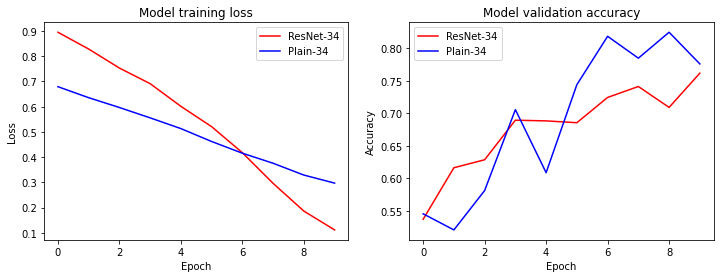

In [40]:
# ResNet-34 vs Plain-34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()


## 프로젝트 결과 및 회고
- 이번 프로젝트는 블록 구현을 통해 resnet과 plainet을 구현하고 tfds의 데이터셋을 활용하여 정상적으로 구현한 모델이 작동하는지 확인하는 프로젝트입니다.
- 우선 이번 프로젝트를 진행하며 가장 어려웠던 부분은 tfds에서 cat vs dogs 데이터셋을 불러와 원하는 형태로 처리하는 것이었는데 tfds의 cat vs dogs 데이터셋의 주소가 바뀌었는지 정상적인 tfds.load로는 불러오는 것이 불가능해서 이를 해결하는데 오래걸렸습니다.
- 다음으로 resnet의 구조도를 보고 블록형태로 이를 구현하였는데 정답으로 제시된 summary와 동일한 파라미터 수를 맞추는 것이 힘들었습니다.
- 마지막으로 결과를 확인하였을 때 적은 수(10 epoch)이지만 epoch이 진행될수록 loss 값이 감소하고 accuracy 값이 올라가는 것을 확인할 수 있었습니다.